In [1]:
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image

In [2]:
from tqdm import tqdm
import cv2
import json

In [3]:
!ls /nas/chenyi/datasets_cls/wardrobe500k/dadetv62_20220715

crops  images  labels


In [4]:
feat_p = '/nas/chenyi/share/xtc/gallery_crop_features_clothes.txt'

In [6]:
def txt_readlines(feat_p):
    with open(feat_p, 'r') as f:
        feat_data = f.readlines()
    return feat_data

In [7]:
# %%time
# feat_data = txt_readlines(feat_p)
# len(feat_data)

In [8]:
def parse_line(line):
    line_list = line.split('\t')
    crop_path = line_list[0]
    feat_list = line_list[1].split(',')
    return crop_path, feat_list
    # return crop_path

In [10]:
# data4parse = feat_data[:]
# pathes = []
# feat_all_list = []
# stem2feat = {}
# for line in tqdm(data4parse):
#     try:
#         crop_path, feat_list = parse_line(line)
#         crop_path = Path(crop_path)
#         stem = f'{crop_path.parts[-2]}/{crop_path.name}'
#         stem2feat[stem] = np.array(feat_list).astype(np.half)
#     except:
#         print(crop_path)

100%|███████████████| 2168673/2168673 [03:07<00:00, 11551.89it/s]


In [10]:
# data4parse = feat_data[:]
# pathes = []
# feat_all_list = []
# for line in tqdm(data4parse):
#     try:
#         crop_path, feat_list = parse_line(line)
#         pathes.append(crop_path)
#         feat_all_list.append(np.array(feat_list).astype(np.half))
#     except:
#         print(crop_path)

In [16]:
feat_df = pd.DataFrame((feat_all_list))

In [20]:
feat_df['crop_p'] = pathes

#### 数据保存

In [11]:
# import pickle 
# with open('./data/stem2feature.pickle', 'wb') as f:
#     pickle.dump(stem2feat, f)

In [11]:
feat_df = pd.read_csv('./data/feat_all_df.csv')

In [133]:
# feat_df.to_csv('./data/feat_all_df.csv', index=False)

In [437]:
# feat_skirt_df.to_csv('./data/feat_skirt_df.csv', index=False)

In [136]:
!du -h ./data/*.csv

149M	./data/df_len2.csv
2.1G	./data/feat_all_df.csv
204M	./data/feat_skirt_df.csv
267M	./data/img_color_cy_0712.csv
149M	./data/len2_df.csv
83M	./data/org_img_df.csv


### 距离

In [12]:
from pandarallel import pandarallel
# Initialization
pandarallel.initialize()
# Parallel apply
# df.parallel_apply(func)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [13]:
# %%time
# root_crop = Path('/nas/oss/clothes_new')
# feat_df['crop_sp'] = feat_df['crop_sp'].parallel_apply(lambda x: root_crop / Path(x).name[:2]/Path(x).name[2:4]/Path(x).name)

In [34]:
# %%time
# feat_df['class_l1'] = feat_df['crop_p'].parallel_apply(lambda x: Path(x).parts[-2])

CPU times: user 305 ms, sys: 857 ms, total: 1.16 s
Wall time: 4.68 s


In [35]:
# %%time
# feat_df['stem'] = feat_df['crop_p'].parallel_apply(lambda x: Path(x).stem)

CPU times: user 533 ms, sys: 987 ms, total: 1.52 s
Wall time: 4.78 s


In [14]:
feat_df.value_counts('class_l1')

class_l1
upperbody    915056
lowerbody    581170
wholebody    462944
skirt        209503
dtype: int64

#### 单例计算距离

In [126]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

a1=np.arange(15).reshape(3,5)
a2=np.arange(20).reshape(4,5)

cosine_similarity(a1,a2)   #第一行的值是a1中的第一个行向量与a2中所有的行向量之间的余弦相似度
# cosine_similarity(a1)   #a1中的行向量之间的两两余弦相似度

array([[1.        , 0.91465912, 0.87845859, 0.86154979],
       [0.91465912, 1.        , 0.99663684, 0.99323905],
       [0.87845859, 0.99663684, 1.        , 0.9994114 ]])

In [127]:
a1

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

In [15]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
 

# 标准化
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

In [129]:
def cosine_similarity_np(x,y):
    num = x.dot(y.T)
    denom = np.linalg.norm(x) * np.linalg.norm(y)
    return num / denom

In [187]:
# def cosine_similarity_axis(x,y):
#     num = x.dot(y.T)
#     denom = np.linalg.norm(x, axis=1) * np.linalg.norm(y, axis=1)
#     return num / denom

In [17]:
feat_skirt_df = feat_df[feat_df['class_l1']=='skirt'].copy(deep=True)
data = feat_skirt_df.iloc[:, 0:128].values

In [18]:
%%time
for ind, x in enumerate(data.T):
    feat_skirt_df.iloc[:, ind] = normalization(x)
    # break

CPU times: user 71.6 ms, sys: 0 ns, total: 71.6 ms
Wall time: 89.9 ms


In [413]:
data_n = feat_skirt_df.iloc[:, 0:128].values

In [414]:
ind = 1705122
sample_df = feat_skirt_df.loc[ind, :]
# feat_sample = data_n[ind]
feat_sample = sample_df.iloc[:128].values
dist_list = []
for x in tqdm(data_n):
    dist_list.append(cosine_similarity_np(feat_sample, x))

100%|██████████████████████████████| 209503/209503 [00:04<00:00, 47404.97it/s]


In [415]:
feat_skirt_df.iloc[:, 0:128] = data_n

In [416]:
# %%time
# data_s=standardization(data_n)

In [417]:
# x0 = feat_df.iloc[0, 0:128].values
# x1 = feat_df.iloc[1, 0:128].values

In [418]:
# x0 = data_n[0, 0:128]
# x1 = data_n[1, 0:128]
# cosine_similarity(x0, x1)

##### 重排序测试

In [419]:
nums_rerank = int(1e4)
feat1_df = feat_skirt_df.loc[:, :]
feat1_df['dist'] = dist_list
rerank_df = feat1_df.sort_values('dist', ascending=False)[:nums_rerank]
rerank_df.reset_index(inplace=True)

In [421]:
# data_n = rerank_df.iloc[:, 1:129].values.astype(np.half)
data_n = rerank_df.iloc[:, 1:129].values

In [422]:
# dist_matrix = []
# for x in tqdm(data_n):
#     x_list = []
#     for y in data_n:
#         x_list.append(cosine_similarity(x, y))
#     dist_matrix.append(x_list)

In [423]:
%%time
dist_matrix = cosine_similarity(data_n, data_n)

CPU times: user 2.15 s, sys: 2.75 s, total: 4.9 s
Wall time: 789 ms


In [424]:
arg_num = 50
rank_matrix = np.argsort(dist_matrix, axis=0)[-arg_num:]

In [425]:
len(rank_matrix[0]), len(rerank_df)

(10000, 10000)

In [426]:
score_rank = arg_num-rank_matrix
score_rank[score_rank<0] = 0

In [427]:
rerank_df['rank'] = score_rank.sum(axis=0)

In [428]:
rerank_df.sort_values('rank', ascending=False, inplace=True)

### Display

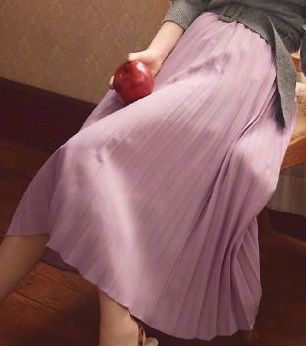

In [429]:
# i = 3
# sample_p = feat_skirt_df['crop_sp'].values[80000+i]
sample_p = sample_df['crop_sp']
Image.open(sample_p)

#### html

In [430]:
import sys
sys.path.append('../')

In [431]:
from utils.display.html import *

In [433]:
feat1_df = feat_skirt_df.loc[:, ['crop_sp', 'class_l1', 'stem']]
feat1_df['dist'] = dist_list
dis_df = feat1_df.sort_values('dist', ascending=False)[:100]
dis_df['image'] = dis_df['crop_sp'].map(lambda f: get_thumbnail(f, size=250))
# HTML(dis_df[['image', 'dist', 'stem']].to_html(formatters={'image': image_formatter}, escape=False))

In [434]:
dis_df.head(1)

,crop_sp,class_l1,stem,dist,image
1705122,/nas/oss/clothes_new/ba/a6/baa6ac93-c0f9-4dc3-9c6f-db5a57c98bee-352125_0.jpg,skirt,baa6ac93-c0f9-4dc3-9c6f-db5a57c98bee-352125_0,1.0,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=221x250 at 0x7FA04DE18520>


In [435]:
dis_rerank_df.head(1)

,index,0,1,2,3,4,5,6,7,8,...,125,126,127,crop_sp,class_l1,stem,dist,rank,image,image_dist
0,1786221,0.211272,0.623519,0.5809,0.626439,0.694857,0.461293,0.661958,0.44375,0.497108,...,0.427705,0.663612,0.3064,/nas/oss/clothes_new/fd/27/fd277845-cb09-4ff5-ad8c-ec45f1a5800c-701598_2.jpg,skirt,fd277845-cb09-4ff5-ad8c-ec45f1a5800c-701598_2,1.0,1275,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=125x250 at 0x7F9EFF4BCDC0>,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=125x250 at 0x7F9EFF4E1D90>


/tmp/ipykernel_2699294/4044714370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_rerank_df['image'] = dis_rerank_df['crop_sp'].map(lambda f: get_thumbnail(f, size=250))
/tmp/ipykernel_2699294/4044714370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_rerank_df['image_dist'] = dis_df['image'].values[:50]


,image,image_dist,dist,rank,stem
0,,,1.000000,1275,baa6ac93-c0f9-4dc3-9c6f-db5a57c98bee-352125_0
2,,,0.994758,793,e181dedf-1aac-459d-9985-11e36b7e6418-144524_1
1,,,0.995122,706,41ed0f68-2d64-49b3-a974-4a0445ad7918-137019_3
9,,,0.993798,599,762512b5-a1af-11ec-a819-5cfb3aa6f5e6_2
14,,,0.993332,582,b989ac65-2f9c-4113-a392-4353284f8b05-724376_1
20,,,0.993082,558,00356a88-9c7f-4383-a91a-1fda6a5bbc5b-842928_0
4,,,0.994510,547,6edfcb14-908d-11ec-b38d-5cfb3aa6f5e6_1
19,,,0.993085,536,1ad4cc1c-ac0d-11ec-b049-5cfb3aa6f5e6_1
5,,,0.994477,536,0050d03d-638b-44bc-9799-96aace73a779-835322_0
7,,,0.994014,510,a75f7263-a1d5-11ec-afb6-5cfb3aa6f5e6_0

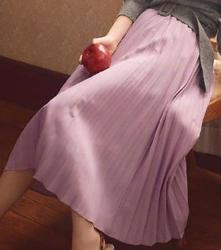
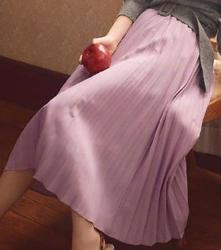
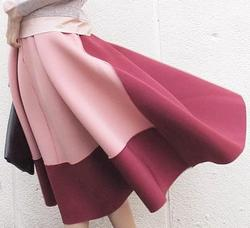
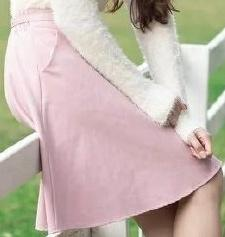
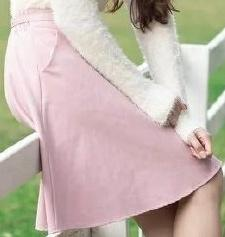
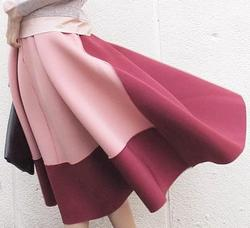
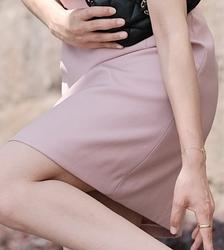
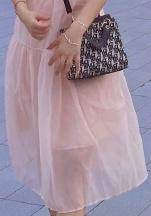
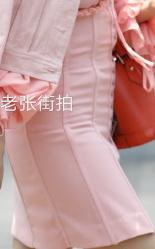
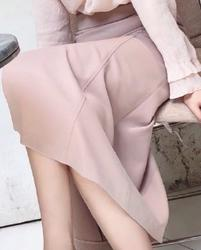
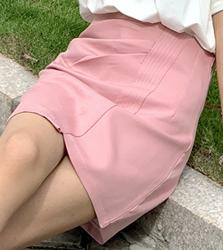
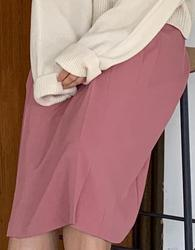
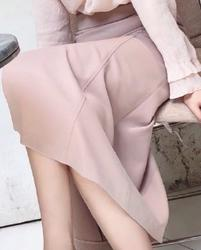
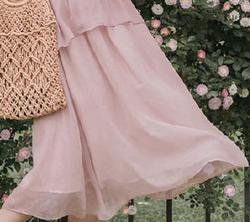
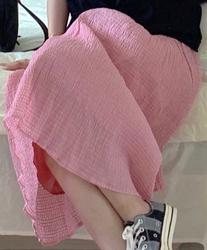
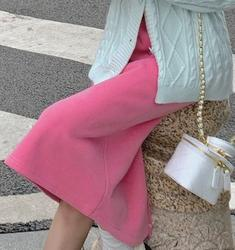
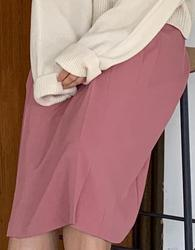
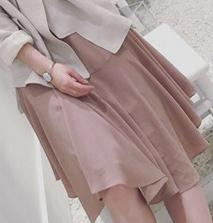
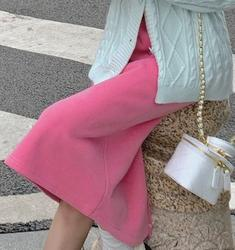
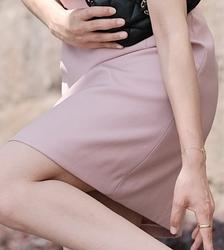
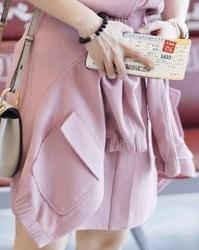
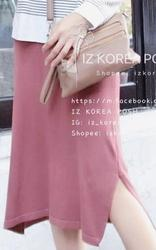
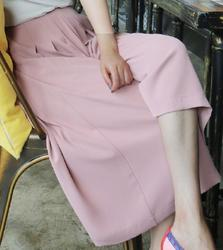
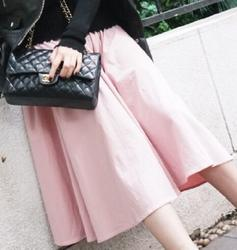
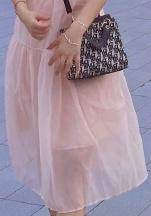
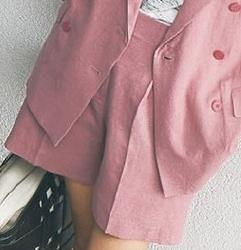
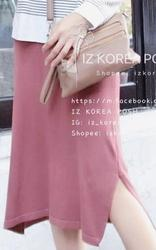
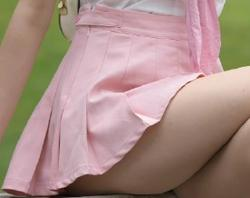
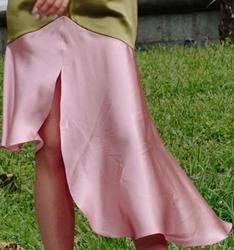
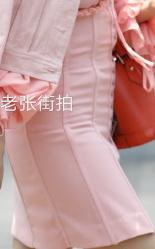
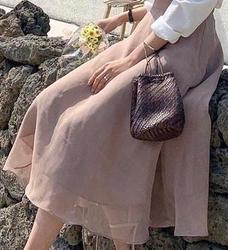
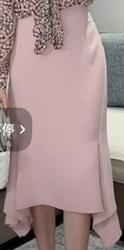
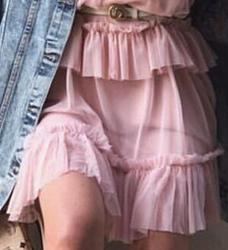
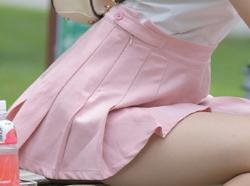
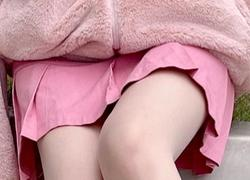
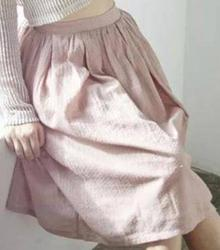
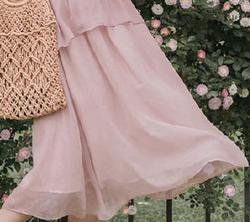
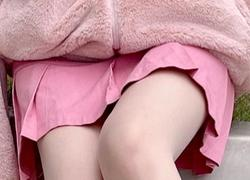
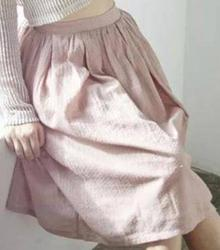
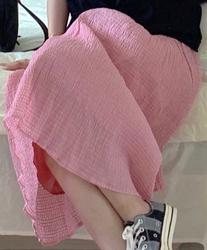
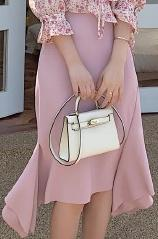
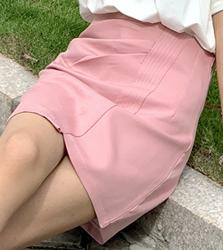
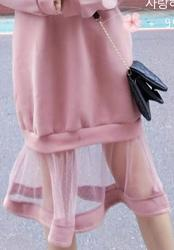
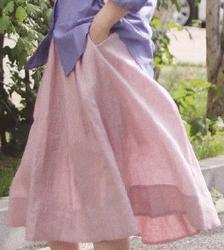
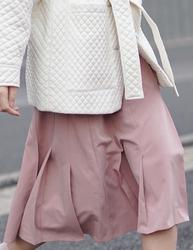
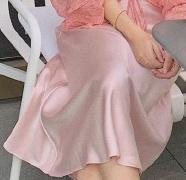
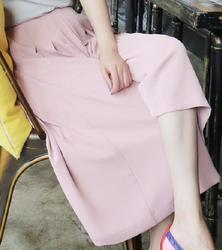
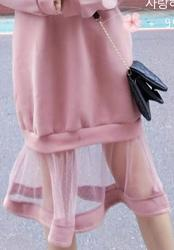
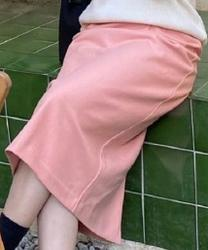
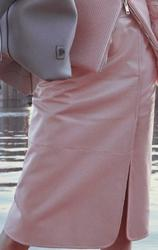
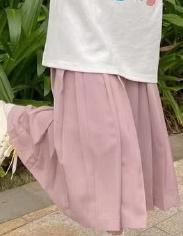
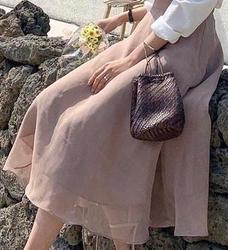
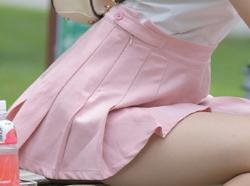
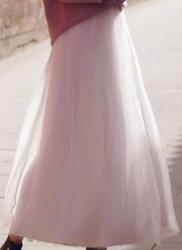
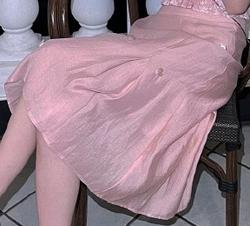
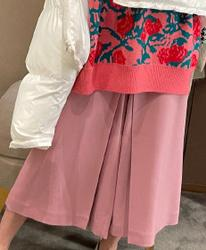
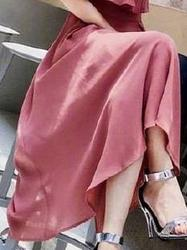
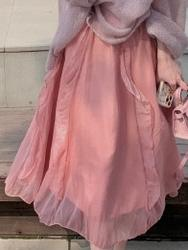
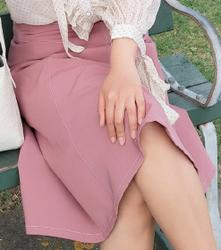
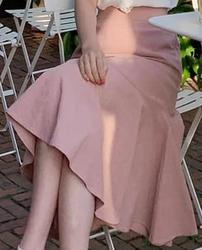
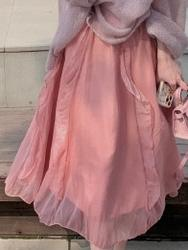
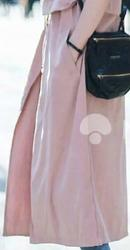
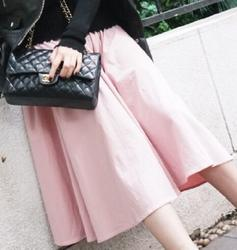
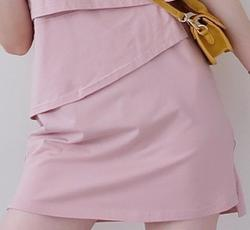
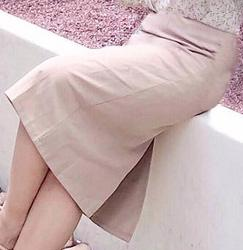
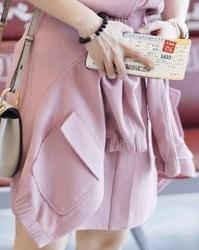
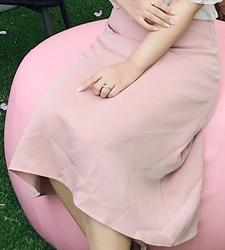
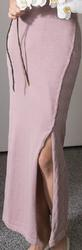
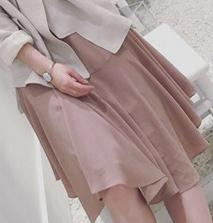
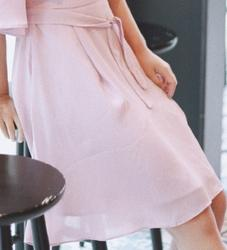
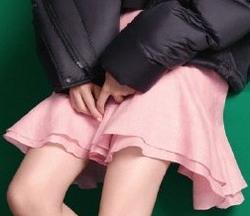
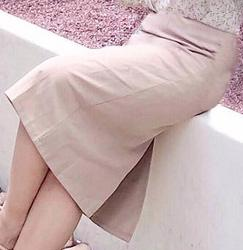
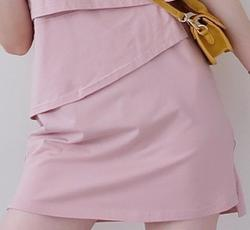
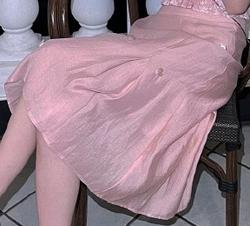
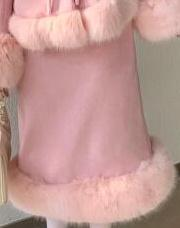
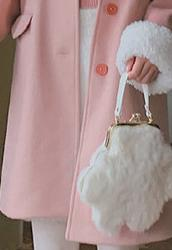
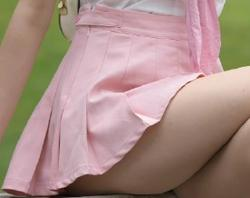
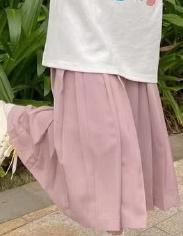
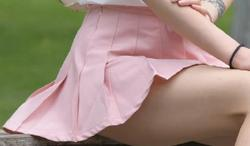
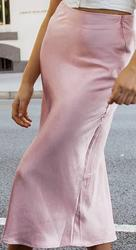
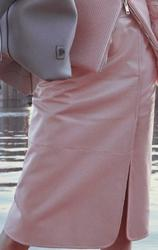
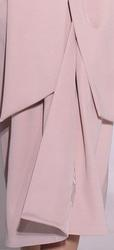
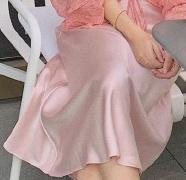
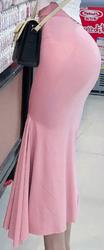
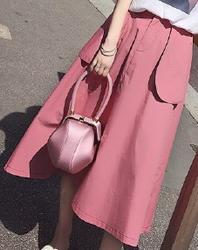
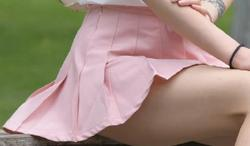
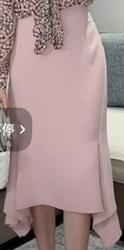
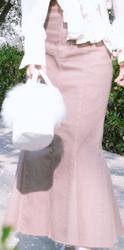
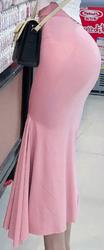
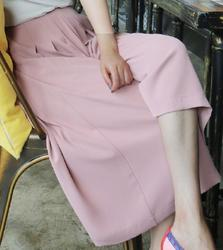
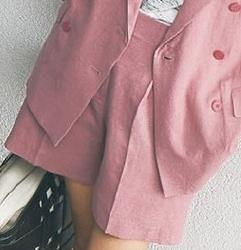
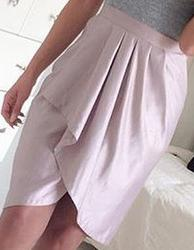
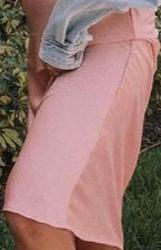
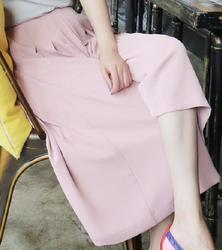
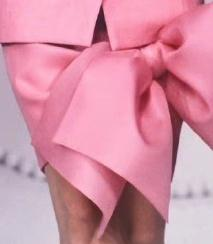
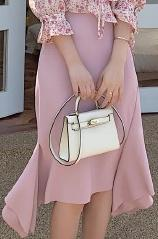
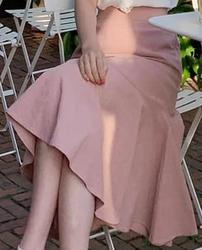
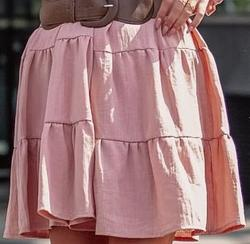
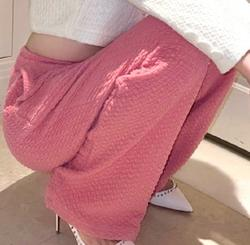
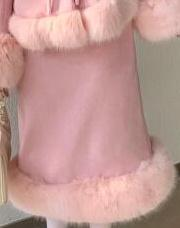

In [436]:
dis_rerank_df = rerank_df[:50]
dis_rerank_df['image'] = dis_rerank_df['crop_sp'].map(lambda f: get_thumbnail(f, size=250))
dis_rerank_df['image_dist'] = dis_df['image'].values[:50]
HTML(dis_rerank_df[['image', 'image_dist', 'dist', 'rank','stem']].to_html(formatters={'image': image_formatter, 
                                                                                       'image_dist': image_formatter},
                                                                                       escape=False))

In [ ]:
feat1_df = feat_skirt_df.loc[:, ['crop_sp', 'class_l1', 'stem']]
feat1_df['dist'] = dist_list
dis_df = feat1_df.sort_values('dist', ascending=False)[:50]
dis_df['image'] = dis_df['crop_sp'].map(lambda f: get_thumbnail(f, size=250))
HTML(dis_df[['image', 'dist', 'stem']].to_html(formatters={'image': image_formatter}, escape=False))

In [ ]:
feat1_df = feat_skirt_df.loc[:, ['crop_sp', 'class_l1', 'stem']]
feat1_df['dist'] = dist_list
dis_df = feat1_df.sort_values('dist', ascending=False)[:50]
dis_df['image'] = dis_df['crop_sp'].map(lambda f: get_thumbnail(f, size=250))
HTML(dis_df[['image', 'dist', 'stem']].to_html(formatters={'image': image_formatter}, escape=False))

,image,dist,stem
1759134,,0.944479,6f18e80a-a253-11ec-aa57-50814025d3e9_1
1755125,,0.944479,5f433d4c-90c3-11ec-b468-5cfb3aa6f5e6_1
1705122,,0.944479,baa6ac93-c0f9-4dc3-9c6f-db5a57c98bee-352125_0
1609102,,0.944479,175de7d5-7597-4f82-bbe3-33381a8fdbf3-777092_0
1641674,,0.944478,0d3bf944-425f-40ab-8294-7ad3daeb2cf0-734072_1
1811302,,0.944478,c56d2334-04eb-4ff0-b996-81a980e8a6e6-221218_0
1729128,,0.944477,6ae97f79-8f9c-11ec-a6e4-50814025d3e9_0
1633551,,0.944477,95001e62-1f5c-4d98-9aec-138cb33c0983-284580_0
1820519,,0.944476,d4197cf9-f62c-480f-a4ee-3e2fe852c85c-363257_0
1628350,,0.944476,08be1fd8-7051-4b1e-bec0-cbe4ff15e006-311652_1

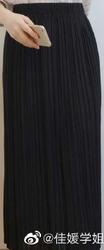
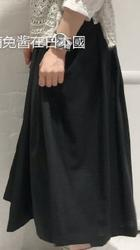
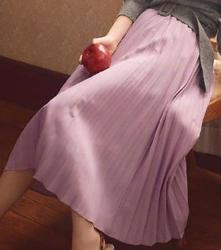
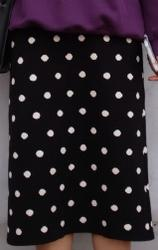
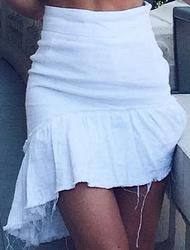
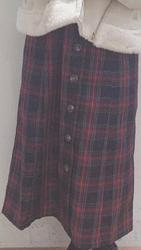
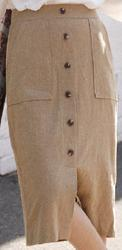
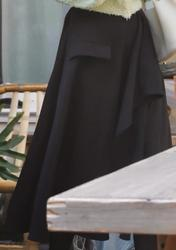
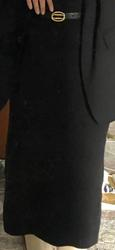
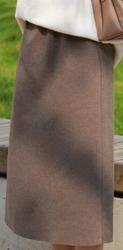
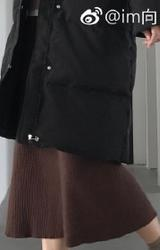
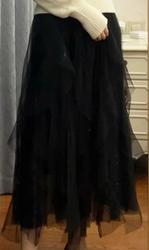
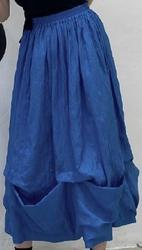
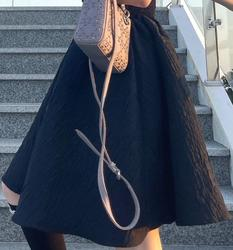
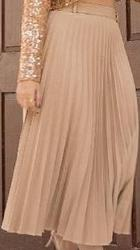
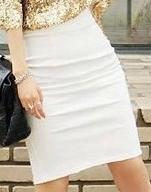
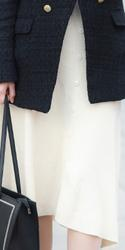
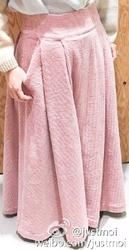
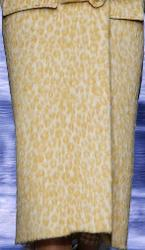
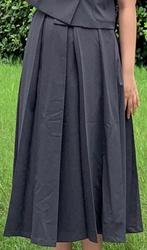
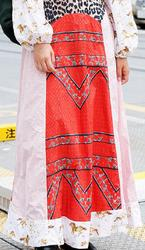
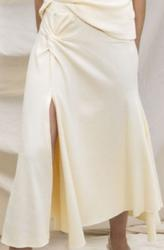
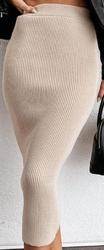
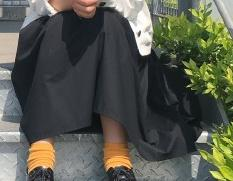
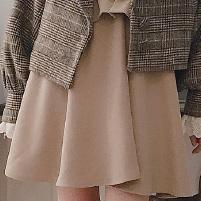
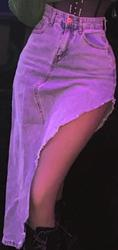
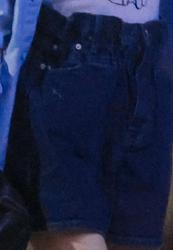
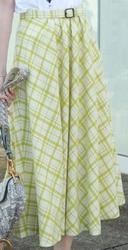
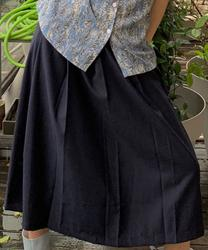
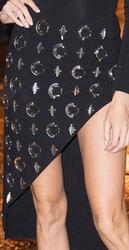
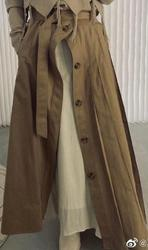
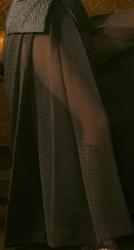
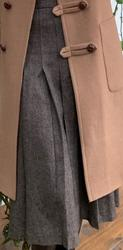
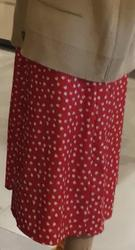
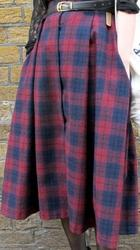
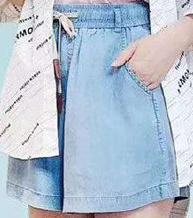
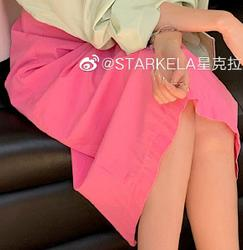
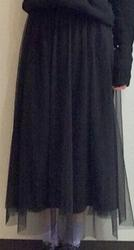
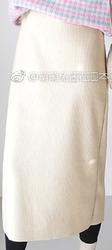
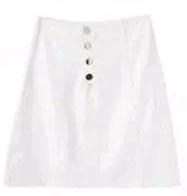
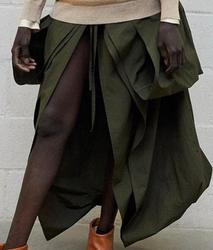
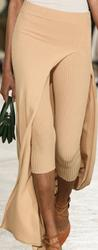
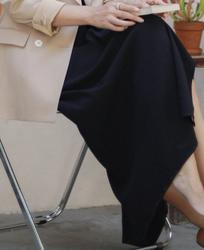
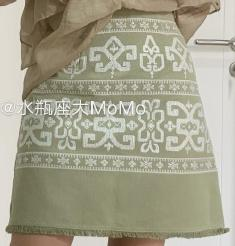
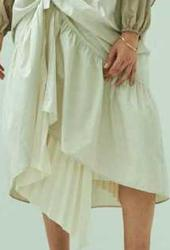
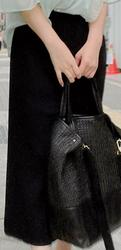
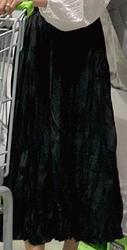
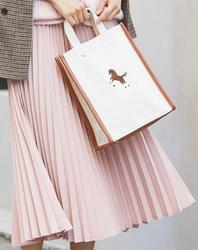
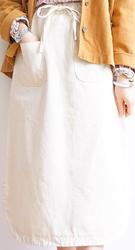
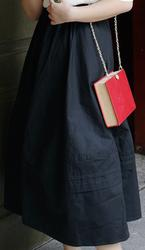

In [293]:
dis_df = feat1_df.sort_values('dist', ascending=False)[-100050:-100000]
dis_df['image'] = dis_df['crop_sp'].map(lambda f: get_thumbnail(f, size=250))
HTML(dis_df[['image', 'dist', 'stem']].to_html(formatters={'image': image_formatter}, escape=False))